In [2]:
import scanpy as sc
import pandas as pd
import numpy as np
import time
import random
import argparse, sys
from scipy.sparse import issparse
from collections import Counter
import torch
from torch.utils.data import DataLoader

from merge_Dataset import PretrainDataset
from main_tcr_train import *
from utils import *


import pickle
import umap
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import normalized_mutual_info_score
from sklearn.decomposition import PCA

In [3]:
# Set display options
pd.set_option('display.max_columns', None)

# --------------------------- Parse config --------------------------- #
argparser = argparse.ArgumentParser()
argparser.add_argument('--config', type=str, default='/data/hxu10/bystander/BTC/config.yaml')
# 在 notebook/pycharm 的 Jupyter 环境中，忽略 sys.argv
IN_JUPYTER = 'ipykernel' in sys.modules
args = argparser.parse_args([] if IN_JUPYTER else None)
config = load_config(args.config)

# Set seed and device
set_random_seed(config['Train']['Trainer_parameter']['random_seed'])
device = config['Train']['Model_Parameter']['device']

In [4]:
# --------------------------- Load and preprocess data --------------------------- #
adata = sc.read_h5ad("../Data/pretrain_raw_data/merge_8dataset_celltypes_combat.h5ad") # harmony_5000gene_corrected.h5ad
if issparse(adata.X):
    adata.X = np.array(adata.X.toarray(), dtype=np.float32)
else:
    adata.X = np.array(adata.X, dtype=np.float32)
dataset = PretrainDataset(adata)
smile_seqs, vocab_dict = dataset.get_smile_seqs()

print("dataset over")

dataset over


In [5]:
# --------------------------- Initialize and optionally load pretrained model --------------------------- #
model = init_model(config, device)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    model.optimizer,
    mode='min',
    factor=0.5,
    patience=10
)
# === DataLoader ===
dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=config['Train']['Sampling']['batch_size'],
    shuffle=config['Train']['Sampling']['sample_shuffle']
)
# === Logger === #
output_dir = config['Train']['output_dir']
logger = get_logger(f"{config['Train']['output_dir']}/training_8_datasets_AE.log")
# === Training Params ===
epochs = config['Train']['Trainer_parameter']['epoch']
patience = config['Train']['Trainer_parameter']['patience']
best_loss = float('inf')


In [ ]:
# === Metrics Storage ===
all_loss = []
number_of_GEO = len(Counter(dataset.GEOlabel))
#number_of_beta = len(Counter(dataset.cdr3))
number_of_type = len(Counter(dataset.type))

enc_geo = LabelEncoder().fit(dataset.GEOlabel)
#enc_beta = LabelEncoder().fit(dataset.cdr3)
enc_type = LabelEncoder().fit(dataset.type)

for epoch in range(1, epochs + 1):
   total_contrastive, total_recon, total_fusion, epoch_loss = 0,0,0,0
   start_time = time.time()

   avg_loss, avg_components, all_embeddings, all_rna_embeddings, all_tcr_embeddings, all_GEO_labels, all_beta_labels, all_type_labels = train_one_epoch(model, dataloader, device)
   all_loss.append(avg_loss)
   logger.info(
       f"Epoch [{epoch}/{epochs}] | Loss : {avg_loss:.5f} | "
       f"Contrastive: {avg_components['tcr']:.5f} | "
       f"Recon: {avg_components['rna']:.5f} | "
       f"Fusion: {avg_components['fusion']:.5f} | "
       f"Time: {time.time() - start_time:.2f}s"
   )

   ######## save best model ###########
   if avg_loss < best_loss:
       best_loss = avg_loss
       early_stop_counter = 0
       best_epoch_model = model.state_dict()
       save_best_model(model, epoch, output_dir, stage="pretrain_after_batchremove")
   else:
       early_stop_counter += 1

   if early_stop_counter >= patience:
       logger.info(f"Early stopping at epoch {epoch}. No improvement for {patience} epochs.")
       break

print("train over")

[2025-08-20 10:26:44,376][3876574735.py][line:17][INFO] Epoch [1/300] | Loss : 4.46244 | Contrastive: 3.54034 | Recon: 1.80004 | Fusion: 0.89222 | Time: 75.11s             
[2025-08-20 10:28:00,364][3876574735.py][line:17][INFO] Epoch [2/300] | Loss : 2.89430 | Contrastive: 2.63574 | Recon: 1.39232 | Fusion: 0.18411 | Time: 75.17s             
[2025-08-20 10:29:18,620][3876574735.py][line:17][INFO] Epoch [3/300] | Loss : 2.45734 | Contrastive: 2.36669 | Recon: 1.16246 | Fusion: 0.11153 | Time: 77.43s             
[2025-08-20 10:30:36,927][3876574735.py][line:17][INFO] Epoch [4/300] | Loss : 2.24555 | Contrastive: 2.24142 | Recon: 1.04200 | Fusion: 0.08285 | Time: 77.46s             
[2025-08-20 10:31:53,754][3876574735.py][line:17][INFO] Epoch [5/300] | Loss : 2.12822 | Contrastive: 2.15530 | Recon: 0.98073 | Fusion: 0.06983 | Time: 75.91s             
[2025-08-20 10:33:11,330][3876574735.py][line:17][INFO] Epoch [6/300] | Loss : 1.98038 | Contrastive: 2.08157 | Recon: 0.87860 | Fusion

In [5]:
# visual
final_embeddings_np = np.vstack(all_embeddings)
final_GEO_cluster_labels = np.array(all_GEO_labels)
final_beta_cluster_labels = np.array(all_beta_labels)
final_type_cluster_labels = np.array(all_type_labels)

reducer_all = umap.UMAP(
    n_components=2,
    n_neighbors=50,
    min_dist=0.1,
    metric='cosine',
    n_jobs=-1
)
reduced_embeddings_umap = reducer_all.fit_transform(final_embeddings_np)
print("umap all embedding")

# rna
final_rna_embeddings_np = np.vstack(all_rna_embeddings)
reducer_rna = umap.UMAP(
    n_components=2,
    n_neighbors=50,
    min_dist=0.1,
    metric='cosine',
    n_jobs=-1
)
rna_reduced_embeddings_umap = reducer_rna.fit_transform(final_rna_embeddings_np)
print("rna_embeddings_umap over")
# tcr
final_tcr_embeddings_np = np.vstack(all_tcr_embeddings)
reducer_tcr = umap.UMAP(
    n_components=2,
    n_neighbors=50,
    min_dist=0.1,
    n_jobs=-1
)
tcr_reduced_embeddings_umap = reducer_tcr.fit_transform(final_tcr_embeddings_np)
print("tcr_embeddings_umap over")

umap all embedding
rna_embeddings_umap over
tcr_embeddings_umap over


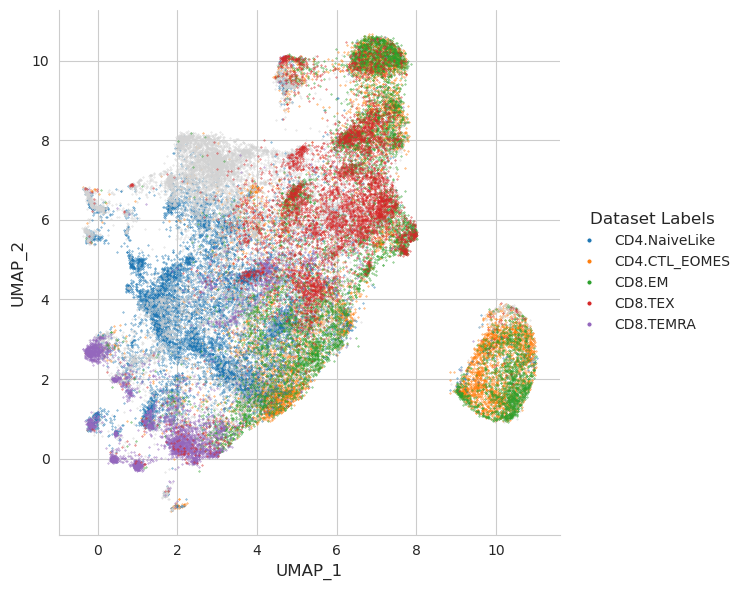

In [6]:
# plot
draw_reduced_embeddings_umap = reduced_embeddings_umap
visiual_label = final_type_cluster_labels # visiual_label = np.array(adata.obs['cdr3'])

unique_labels = np.unique(visiual_label)
label_counts = Counter(visiual_label)
top_labels = [label for label, _ in label_counts.most_common(5)]
top_colors = [plt.cm.tab10(i) for i in range(len(top_labels))]
label2color = {label: top_colors[i] for i, label in enumerate(top_labels)}
plt.figure(figsize=(8, 6))
for label in unique_labels:
    mask = visiual_label == label
    color = label2color.get(label, 'lightgray')  # 非top类默认灰色
    plt.scatter(
        draw_reduced_embeddings_umap[mask, 0],
        draw_reduced_embeddings_umap[mask, 1],
        color=color,
        s=0.1,
        label=str(label) if label in top_labels else None  # 避免重复图例
    )
legend_handles = [
    Line2D([0], [0], marker='o', color='w',
           markerfacecolor=label2color[label],
           label=label, markersize=4)
    for label in top_labels
]
plt.legend(
    handles=legend_handles,
    title="Dataset Labels",
    loc='center left',
    bbox_to_anchor=(1.02, 0.5),
    markerscale=1,
    fontsize=10,
    title_fontsize=12,
    borderaxespad=0,
    frameon=False
)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.xlabel('UMAP_1', fontsize=12)
plt.ylabel('UMAP_2', fontsize=12)
plt.gca().set_aspect('equal', adjustable='box')
plt.tight_layout()
plt.show()
# plt.savefig("umap_final_beta_cluster_labels.png", dpi=300, bbox_inches='tight')
